In [1]:
!nvidia-smi

Sat Jun 11 22:51:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Dataset_capstone_final.zip'

In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os 

dir_i = os.listdir('/content/Dataset_img_final')

for i in dir_i:
  dir_a = os.path.join('/content/Dataset_img_final', i)
  print(i, ' memiliki ', len(os.listdir(dir_a)))

orthopaedic wounds  memiliki  49
miscellaneous  memiliki  56
leg-ulcer-images  memiliki  134
foot-ulcers  memiliki  384
pressure ulcer  memiliki  856
epidermolysis-bullosa  memiliki  5
toes  memiliki  35
haemangioma  memiliki  6
DFU  memiliki  673
burns  memiliki  457
malignant-wound-images  memiliki  9
meningitis  memiliki  24
normal  memiliki  300
venous  memiliki  411
extravasation-wound-images  memiliki  20
pilonidal-sinus  memiliki  3
surgical  memiliki  420
skin tears  memiliki  54
abdominal-wounds  memiliki  13
trauma  memiliki  93


In [6]:
!mv "/content/Dataset_img_final/pilonidal-sinus" "/content/content"
!mv "/content/Dataset_img_final/haemangioma" "/content/content"
!mv "/content/Dataset_img_final/epidermolysis-bullosa" "/content/content"
!mv "/content/Dataset_img_final/extravasation-wound-images" "/content/content"
!mv "/content/Dataset_img_final/malignant-wound-images" "/content/content"
!mv "/content/Dataset_img_final/abdominal-wounds" "/content/content"
!mv "/content/Dataset_img_final/meningitis" "/content/content"
!mv "/content/Dataset_img_final/toes" "/content/content"
!mv "/content/Dataset_img_final/miscellaneous" "/content/content"
!mv "/content/Dataset_img_final/skin tears" "/content/content"
!mv "/content/Dataset_img_final/trauma" "/content/content"
!mv "/content/Dataset_img_final/orthopaedic wounds" "/content/content"
!mv "/content/Dataset_img_final/leg-ulcer-images" "/content/content"
!mv "/content/Dataset_img_final/normal" "/content/content"
!mv "/content/Dataset_img_final/DFU" "/content/content"

In [7]:
import splitfolders

folder = '/content/Dataset_img_final'

splitfolders.ratio(folder, output='/content/Dataset_split',
                 seed=42, ratio=(0.8, 0.2),
                 group_prefix = None
                 )

Copying files: 2528 files [00:00, 6489.78 files/s]


In [8]:
import os 

dir_i = os.listdir('/content/Dataset_split/train')

for i in dir_i:
  dir_a = os.path.join('/content/Dataset_split/train', i)
  print(i, ' memiliki ', len(os.listdir(dir_a)))

foot-ulcers  memiliki  307
pressure ulcer  memiliki  684
burns  memiliki  365
venous  memiliki  328
surgical  memiliki  336


In [9]:
import os 

dir_i = os.listdir('/content/Dataset_split/val')

for i in dir_i:
  dir_a = os.path.join('/content/Dataset_split/val', i)
  print(i, ' memiliki ', len(os.listdir(dir_a)))

foot-ulcers  memiliki  77
pressure ulcer  memiliki  172
burns  memiliki  92
venous  memiliki  83
surgical  memiliki  84


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/Dataset_split/train'
val_dir = '/content/Dataset_split/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
import tensorflow as tf
import urllib.request
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionResNetV2

pre_trained_model = InceptionResNetV2(input_shape=(150,150,3),
                                    include_top=False,
                                    weights='imagenet')

pre_trained_model.summary()

In [12]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('activation_120')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    ) 
validation_generator = train_datagen.flow_from_directory(
    val_dir, 
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    )

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True)
model_2 = Model(pre_trained_model.input, x)
model_2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

Found 2020 images belonging to 5 classes.
Found 508 images belonging to 5 classes.


In [13]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [14]:
history = model_2.fit(train_generator,
            steps_per_epoch= 2020/32,
            validation_steps= 508/32,
            epochs=100,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[callbacks,mc]
            )


Epoch 1/100
64/63 [==============================] - ETA: 0s - loss: 1.1339 - acc: 0.5990
Epoch 1: val_acc improved from -inf to 0.69882, saving model to best_model_1.h5
63/63 [==============================] - 44s 443ms/step - loss: 1.1339 - acc: 0.5990 - val_loss: 0.8230 - val_acc: 0.6988
Epoch 2/100
64/63 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.7569
Epoch 2: val_acc improved from 0.69882 to 0.74016, saving model to best_model_1.h5
63/63 [==============================] - 26s 415ms/step - loss: 0.6794 - acc: 0.7569 - val_loss: 0.7010 - val_acc: 0.7402
Epoch 3/100
64/63 [==============================] - ETA: 0s - loss: 0.5171 - acc: 0.8153
Epoch 3: val_acc improved from 0.74016 to 0.77953, saving model to best_model_1.h5
63/63 [==============================] - 25s 394ms/step - loss: 0.5171 - acc: 0.8153 - val_loss: 0.6551 - val_acc: 0.7795
Epoch 4/100
64/63 [==============================] - ETA: 0s - loss: 0.4092 - acc: 0.8545
Epoch 4: val_acc did not imp

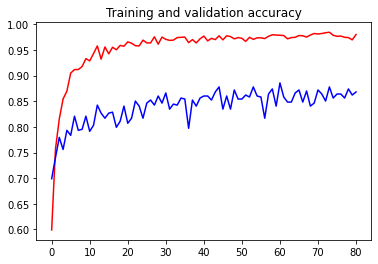

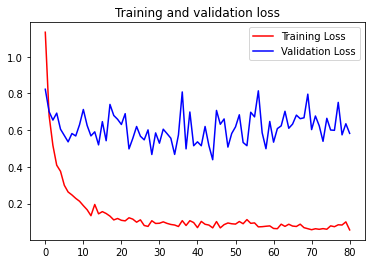

In [15]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()